# Respond in a format

The typical ReAct agent prompts the LLM to respond in 1 of two formats: a function call (~ JSON) to use a tool, or conversational text to respond to the user.

If your agent is connected to a structured (or even generative) UI, or if it is communicating with another agent or software process, you may want it to resopnd in a specific structured format.

In this example we will build a conversational ReAct agent that responds in a specific format. We will do this by using [tool calling](https://python.langchain.com/docs/modules/model_io/chat/function_calling/). This is useful when you want to enforce that an agent's response is in a specific format. In this example, we will ask it respond as if it were a weatherman, returning the temperature and additional info in separate, machine-readable fields.

## Setup

First we need to install the packages required

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-anthropic

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [2]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

## Set up the State

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a `State` object that it passes around to each node.
Each node then returns operations the graph uses to `update` that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the `State` object you use to construct the graph.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is "append-only".

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# Add messages essentially does this with more
# robust handling
# def add_messages(left: list, right: list):
#     return left + right


class State(TypedDict):
    messages: Annotated[list, add_messages]

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use create a placeholder search engine.
It is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/modules/agents/tools/custom_tools) on how to do that.


In [4]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    return ["The weather will be sunny with a high of 27 C."]


tools = [search]

We can now wrap these tools in a simple [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode).
This is  a simple class that takes in a list of messages containing an [AIMessages with tool_calls](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.ai.AIMessage.html#langchain_core.messages.ai.AIMessage.tool_calls), runs the tools, and returns the output as [ToolMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.tool.ToolMessage.html#langchain_core.messages.tool.ToolMessage)s.


In [5]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


**MODIFICATION**

We also want to define a response schema for the language model and bind it to the model as a function as well

In [7]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Response(BaseModel):
    """Final response to the user"""

    temperature: float = Field(description="the temperature")
    other_notes: str = Field(description="any other notes about the weather")


# Bind to the actual tools + the response format!
model = model.bind_tools(tools + [Response], tool_choice="any")

## Define the agent state

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is always added to.


In [8]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

**MODIFICATION**

We will change the `should_continue` function to check what function was called. If the function `Response` was called - that is the function that is NOT a tool, but rather the formatted response, so we should NOT continue in that case.

In [9]:
from typing import Literal


# Define the function that determines whether to continue or not
def route(state: AgentState) -> Literal["action", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we need to check what type of function call it is
    if last_message.tool_calls[0]["name"] == Response.__name__:
        return "__end__"
    # Otherwise we continue
    return "action"


# Define the function that calls the model
def call_model(state: AgentState):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

## Define the graph

We can now put it all together and define the graph!

In [10]:
from langgraph.graph import StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    route,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

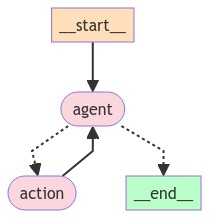

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/docs/expression_language/) as all other LangChain runnables.

In [12]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
for output in app.stream(inputs, stream_mode="values"):
    last_msg = output["messages"][-1]
    last_msg.pretty_print()
    print("\n---\n")

================================ Human Message =================================

what is the weather in sf

---

================================== Ai Message ==================================
Tool Calls:
  search (call_j6mePdJkK2b9TaLKtSfjC9t1)
 Call ID: call_j6mePdJkK2b9TaLKtSfjC9t1
  Args:
    query: weather in San Francisco

---

================================= Tool Message =================================
Name: search

["The weather will be sunny with a high of 27 C."]

---

================================== Ai Message ==================================
Tool Calls:
  Response (call_k2aKLoYXQjEkRFn2ZEpVN4Hl)
 Call ID: call_k2aKLoYXQjEkRFn2ZEpVN4Hl
  Args:
    temperature: 27
    other_notes: Sunny weather

---

